In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [28]:
# open source model from groq
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
api_key = os.getenv("GROQ_API_KEY")
# LLM with function call
llm=ChatGroq(groq_api_key=api_key,model_name="llama-3.1-8b-instant")

In [29]:
# we will use messages to capture different roles within a conversation. 
# Human messages are from the user, AI messages are from the chat model, and system messages are used to set the behavior of the chat model.
# Tool messages are used to represent the output of a tool call.
# Every message has a type and content. name is an optional parameter that can be used to further specify the role of the message/name of the author. 
# response_metadata optionally a dictionary of metadata about the message. often populated by tools to return additional information about the tool call.

from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint # pretty print

messages = [AIMessage(content=f"Hello! How can I assist you today?",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Kirti"))
messages.append(AIMessage(content=f"Which coding language you want to learn?",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Kirti"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Hello! How can I assist you today?
================================ Human Message =================================
Name: Kirti

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which coding language you want to learn?
================================ Human Message =================================
Name: Kirti

I want to learn python programming language


In [30]:
result = llm.invoke(messages)
result.content

'Python is a versatile and widely-used language, known for its simplicity and ease of use. Here\'s a basic outline to get you started:\n\n**Why learn Python?**\n\n1. **Easy to read and write**: Python has a simple syntax and is often considered one of the easiest languages to learn.\n2. **High-level language**: Python abstracts away many low-level details, allowing you to focus on the logic of your program.\n3. **Versatile**: Python can be used for web development, data analysis, machine learning, automation, and more.\n4. **Large community**: Python has a vast and active community, with many resources available for learning and troubleshooting.\n\n**Getting started with Python**\n\n1. **Install Python**: Download and install the latest version of Python from the official Python website.\n2. **Choose a text editor or IDE**: A text editor or Integrated Development Environment (IDE) is where you\'ll write your Python code. Popular choices include PyCharm, Visual Studio Code, and Sublime 

In [31]:
# Tool use with function calling and docstrings
def add(a: int, b: int) -> int:
    """ 
    Add a and b 
    Args: 
        a: first integer
        b: second integer 
    returns:
        integer result
    """
    return a + b

In [32]:
# binding tool with llm
llm_with_tools = llm.bind_tools([add])

In [33]:
result_from_tool = llm_with_tools.invoke([HumanMessage(content="What is 2 + 3 ?",name="Kirti")]) 
# content from aimessage will be empty as result will be generated by addition tool
print(result_from_tool)

content='' additional_kwargs={'tool_calls': [{'id': 'r9qcsccq6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 268, 'total_tokens': 286, 'completion_time': 0.032919215, 'prompt_time': 0.016207917, 'queue_time': 0.044396943, 'total_time': 0.049127132}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--8a5cff70-8dc6-4c52-9759-61706d700a25-0' tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'r9qcsccq6', 'type': 'tool_call'}] usage_metadata={'input_tokens': 268, 'output_tokens': 18, 'total_tokens': 286}


In [34]:
result_from_tool.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'r9qcsccq6',
  'type': 'tool_call'}]

In [35]:
#but result from tool call is not coming in content. so we will use messages as state to see the result
from typing_extensions import TypedDict
from pydantic import BaseModel
from typing import Annotated # we can see all messages in conversation in form of list
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages # reducer to add messages to state

class State(BaseModel):
    messages:Annotated[list[AnyMessage],add_messages]
    #list of AI and Human messages, this will be the information flowing in graph, to avoid overwriting of messages we will use reducer

In [36]:
initial_messages = [AIMessage(content=f"Hello! How can I assist you today?",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Kirti"))
initial_messages


[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Kirti')]

In [37]:
ai_messages = AIMessage(content=f"Which coding language you want to learn?",name="LLMModel")
ai_messages

AIMessage(content='Which coding language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [38]:
# reducer with add_messages. to append messages instead of overwriting
add_messages(initial_messages,ai_messages)

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='8ab3fc42-9efc-417f-99aa-a99eb868ea32'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Kirti', id='cd29ac9d-481f-442b-83d6-fcf33132ee73'),
 AIMessage(content='Which coding language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='4e5609ed-1d0f-4639-ab33-f5375b50c168')]

In [39]:
# llm_tool call as chatbot node in graph
def llm_tool(state:State):
    return {"messages": state.messages + [llm_with_tools.invoke(state.messages)] }

In [40]:
from langgraph.graph import END, StateGraph, START

graph_builder = StateGraph(State)

graph_builder.add_node("llm_tool", llm_tool)

graph_builder.add_edge(START, "llm_tool")
graph_builder.add_edge("llm_tool", END)

graph = graph_builder.compile()

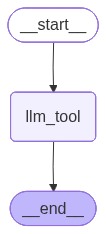

In [41]:
from IPython.display import Image, display
## visualize graph as mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# invocation of graph,
#not getting any output as no tool node is added in graph, only tool is called

graph_result = graph.invoke({"messages":"What is 2 + 5 ?"})

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 + 5 ?
================================== Ai Message ==================================
Tool Calls:
  add (rzfqwqpe7)
 Call ID: rzfqwqpe7
  Args:
    a: 2
    b: 5


In [ ]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

tools = [add]

graph_builder = StateGraph(State)

# nodes
graph_builder.add_node("llm_tool", llm_tool)
graph_builder.add_node("addition_tool", ToolNode(tools))

# if the latest message (result) from assistant is a tool call, then tools_condition route to addition_tool node
# if the latest message (result) from assistant is not a tool call,then tools_condition route to end node
# edges
graph_builder.add_edge(START, "llm_tool")
graph_builder.add_conditional_edges("llm_tool", tools_condition,
                                    {
                                        "tools": "addition_tool",
                                        "__end__": END,  # If no tool call, go to END
                                    },
    )

graph_builder.add_edge("addition_tool", END)

graph = graph_builder.compile()


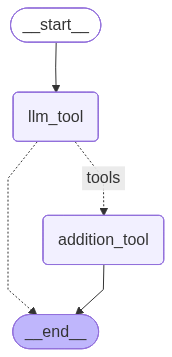

In [50]:
from IPython.display import Image, display
## visualize graph as mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# invocation of graph
# output in tool message as tool node is added in graph

graph_result = graph.invoke({"messages":"What is 2 + 5 ?"})

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 + 5 ?
================================== Ai Message ==================================
Tool Calls:
  add (6mt4pf83m)
 Call ID: 6mt4pf83m
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add

7


In [ ]:
graph_result = graph.invoke({"messages":"What is machine learning?"}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================

brave_search{"query": "what is machine learning"}
